# Creating the Chronos class

There should be a few specs for this method:

* Should have a scikit-learn like interface (fit, predict)
* Should have support for MLE, MAP, MCMC, and SVI
* Parameters should be easy to grab
* Should support arbitrary error distributions
* Should support censored data

In [1]:
import torch
import pyro

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS

In [2]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
my_ts_data.shape

(2905, 2)

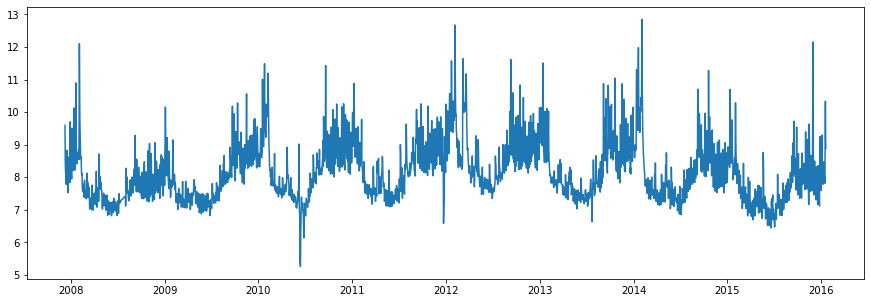

In [4]:
plt.figure(figsize=(15,5))
plt.plot(my_ts_data['ds'], my_ts_data['y'])
plt.show()

In [28]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
from torch.optim import SGD, Rprop
import pyro
import pyro.distributions as dist


# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS
#from pyro.infer import TraceWarning
#warnings.filterwarnings(action='ignore', category=TraceWarning)


#warnings.filterwarnings(
#    action='ignore',
#    module=r'.*infer'
#)

from pyro.optim import ExponentialLR
from pyro.infer import SVI, Trace_ELBO, Predictive, JitTrace_ELBO
from pyro.infer.autoguide import AutoDelta

from torch.distributions import constraints

import warnings
import logging

pyro.enable_validation(True)

torch.set_default_tensor_type(torch.FloatTensor)
class Chronos:
    
    
    def __init__(self, 
                 method="MLE", 
                 time_col = "ds",
                 target_col="y", 
                 year_seasonality_order=10,
                 weekly_seasonality_order=3,
                 learning_rate=0.01,
                 max_iter=1000):
        
        self.method_ = method
        self.n_iter_ = max_iter
        self.lr_ = learning_rate
        
        
        self.year_seasonality_order_ = year_seasonality_order
        self.weekly_seasonality_order_ = weekly_seasonality_order
        
        self.time_col_ = time_col
        self.target_col_ = target_col
        
        
        
    def transform_data(self, data):
        internal_data = data.copy()
        internal_data[self.time_col_] = internal_data[self.time_col_].values.astype(float)/(1e9*60*60*24)
        
        # Yearly seasonality 
        for i in range(1, self.year_seasonality_order_+1):
            internal_data[f"yearly_sin_{i}"] = np.sin(i*2*math.pi*internal_data[self.time_col_]/365.25)
            internal_data[f"yearly_cos_{i}"] = np.cos(i*2*math.pi*internal_data[self.time_col_]/365.25)
            
        # Weekly seasonality
        for i in range(1, self.weekly_seasonality_order_+1):
            internal_data[f"weekly_sin_{i}"] = np.sin(i*2*math.pi*internal_data[self.time_col_]/7)
            internal_data[f"weekly_cos_{i}"] = np.cos(i*2*math.pi*internal_data[self.time_col_]/7)
            
        internal_data.insert(0, "CONST", 1.0)
        
        return internal_data
        
        
        
        
    def fit(self, data):
        
        
        internal_data = self.transform_data(data)
        #display(internal_data)
        
        
        X = torch.tensor(internal_data.drop(self.target_col_, axis=1).values)
        y = torch.tensor(internal_data[self.target_col_].values)
        
        
        if (self.method_ in ["MLE", "MAP"]):
            if (self.method_ == "MLE"):
                print("Employing Maximum Likelihood Estimation")
                self.model = self.model_MLE
                self.guide = self.guide_MLE
                
            elif (self.method_ == "MAP"):
                print("Employing Maximum A Posteriori")
                self.model = self.model_MAP
                self.guide = AutoDelta(self.model_MAP)
                
            # This raises a trace warning
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                self.train_point_estimate(self.model, 
                                          self.guide,
                                          X,
                                          y)
        elif (self.method == "MCMC"):
            print("Employing Markov Chain Monte Carlo")
        
            
            
    ##################################################################
    def train_MCMC(self, model, X, y, sample_num = 3000):
        pass
    
    ##################################################################
    def train_point_estimate(self, model, guide, X, y):
        
        pyro.clear_param_store()
        
        #adam = pyro.optim.ClippedAdam({"lr": self.lr_, "clip_norm": 100.0})
        #optimizer = SGD
        optimizer = Rprop
        scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 
                                              'optim_args': {'lr': self.lr_}, 
                                              'gamma': 0.1})
        
        self.svi_ = SVI(model, 
                        guide, 
                        scheduler, 
                        loss=JitTrace_ELBO())
        
        
        print_interval = max(self.n_iter_//10000, 10)
        
        for step in range(self.n_iter_):
            
            loss = round(self.svi_.step(X, y)/y.shape[0], 4)
            
            if (step % print_interval == 0):
                pct_done = round(100*(step+1)/self.n_iter_, 2)
                
                print(" "*100, end="\r")
                print(f"{pct_done}% - ELBO loss: {loss}", end="\r")
        
        pct_done = round(100*(step+1)/self.n_iter_, 2)
        print(" "*100, end="\r")
        print(f"{pct_done}% - ELBO loss: {loss}", end="\r")
            
    ##################################################################
    
    def model_MLE(self, X, y=None):            
        mu = 0
        for i in range(0, X.size(1)):
            beta_1 = pyro.param(f"beta_{i}", torch.tensor(0.0))
            
            mu += (beta_1 * X[:, i])
            
        
        sigma = pyro.param("sigma", 
                           torch.tensor(1.0), 
                           constraint = constraints.positive)
         
        
        with pyro.plate("data", X.size(0)):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
            
        return mu
        
        
    
    def guide_MLE(self, X, y=None):
        pass
    
    
    ##################################################################
    
    def model_MAP(self, X, y=None):
        
        mu = 0
        for i in range(0, X.size(1)):
            beta_1 = pyro.sample(f"beta_{i}", dist.Normal(0.0, 10.0))
            
            mu += (beta_1 * X[:, i])
            
        #mu += beta_0
        
        sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))
         
        
        with pyro.plate("data", X.size(0)):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
            
        return mu
        
    
    ##################################################################
    def predict(self, data, sample_number=100, ci_interval=0.95):
        internal_data = self.transform_data(data)
        #display(internal_data)
        
        
        X = torch.tensor(internal_data.drop(self.target_col_, axis=1).values)
        y = torch.tensor(internal_data[self.target_col_].values)
        
        if (self.method_ in ["MAP", "MLE"]):
            # https://pyro.ai/examples/bayesian_regression.html#Model-Evaluation
            predictive = Predictive(model=self.model,
                                    guide=self.guide,
                                    num_samples=sample_number,
                                    return_sites=("obs",)) 

            samples = predictive(X)
            
            
            space_on_each_side = (1.0 - ci_interval)/2.0
            lower_ntile = int(len(samples['obs']) * space_on_each_side)
            upper_ntile = int(len(samples['obs']) * (1.0 - space_on_each_side))
            
            predictions = pd.DataFrame({"yhat": torch.mean(samples['obs'], 0).detach().numpy(),
                                        "yhat_lower": samples['obs'].kthvalue(lower_ntile, dim=0)[0].detach().numpy(),
                                        "yhat_upper": samples['obs'].kthvalue(upper_ntile, dim=0)[0].detach().numpy()})
            

            return predictions
        else:
            raise NotImplementedError(f"Did not implement .predict for {self.method_}")

        
        
        
    ##################################################################
    
    ##################################################################
    
    @property
    def intercept_(self):
        if (self.method_ == "MLE"):
            return pyro.param("beta_0").item()
        elif (self.method_ == "MAP"):
            return pyro.param("beta_0_val").item()

    @property
    def coef_(self):
        if (self.method_ == "MLE"):
            return pyro.param("beta_1").item()
        elif (self.method_ == "MAP"):
            return pyro.param("beta_1_val").item()
    
    

In [29]:
my_chronos = Chronos(method="MAP", max_iter=10000, learning_rate=0.001)
my_chronos.fit(my_ts_data)

Employing Maximum A Posteriori


In [30]:
predictions = my_chronos.predict(my_ts_data, sample_number=1000)

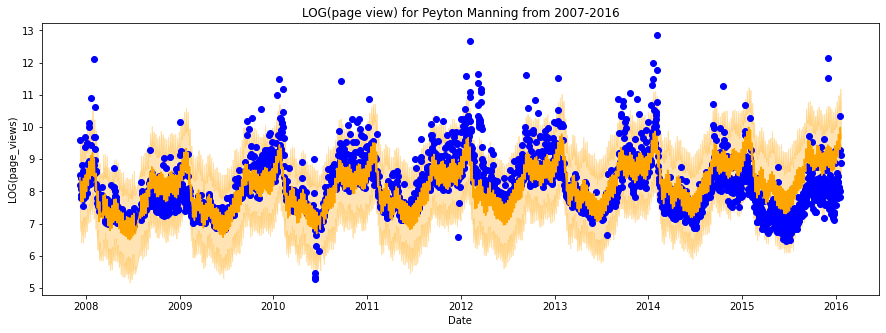

In [31]:
plt.figure(figsize=(15,5))
plt.plot(my_ts_data['ds'], predictions['yhat'], c="orange")
plt.fill_between(my_ts_data['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="orange", alpha=0.3)
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date")
plt.ylabel("LOG(page_views)")
plt.title("LOG(page view) for Peyton Manning from 2007-2016")
plt.show()

In [33]:
my_chronos = Chronos(method="MLE", max_iter=10000, learning_rate=0.01)
my_chronos.fit(my_ts_data)

Employing Maximum Likelihood Estimation


In [34]:
predictions = my_chronos.predict(my_ts_data, sample_number=1000)

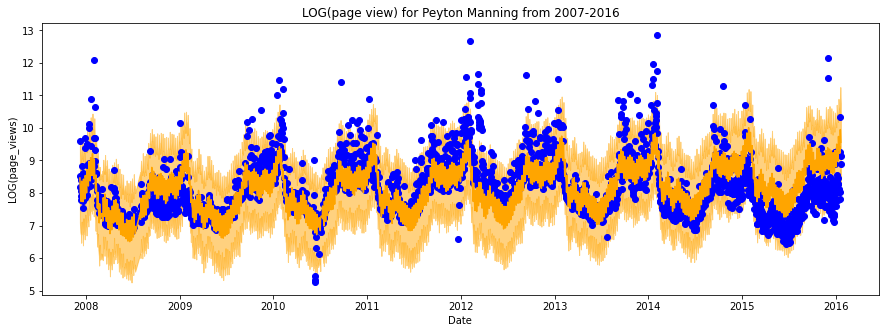

In [35]:
plt.figure(figsize=(15,5))
plt.plot(my_ts_data['ds'], predictions['yhat'], c="orange")
plt.fill_between(my_ts_data['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="orange", alpha=0.5)
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date")
plt.ylabel("LOG(page_views)")
plt.title("LOG(page view) for Peyton Manning from 2007-2016")
plt.show()